<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/barcode_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

# Simulation

In [133]:
# full bc
fbcs = [
  list("GGAGAAGA"),
  list("CCACAATG"),
  list("CCAACCGG"),
  list("CGAAGCCC"),
  list("TCAGTCGA"),
  list("GACCAGCC"),
  list("CTCAAGGT"),
  list("CGCCGCAA"),
  list("ACCAGCCG"),
]
# trim right
rbcs = [
  list("GGAGAAG"),
  list("CCACAAT"),
  list("CCAACCG"),
  list("CGAAGCC"),
  list("TCAGTCG"),
  list("GACCAGC"),
  list("CTCAAGG"),
  list("CGCCGCA"),
  list("ACCAGCC"),
]

# trim left
lbcs = [
  list("GAGAAGA"),
  list("CACAATG"),
  list("CAACCGG"),
  list("GAAGCCC"),
  list("CAGTCGA"),
  list("ACCAGCC"),
  list("TCAAGGT"),
  list("GCCGCAA"),
  list("CCAGCCG"),
]

bcs_names = [
"BC1",
"BC2",
"BC13",
"BC25",
"BC37",
"BC49",
"BC50",
"BC73",
"BC74",
]
bcs_list =[
"GGAGAAGA",
"CCACAATG",
"CCAACCGG",
"CGAAGCCC",
"TCAGTCGA",
"GACCAGCC",
"CTCAAGGT",
"CGCCGCAA",
"ACCAGCCG",
]
bcs = fbcs

# Simulate barcodes with errors and assign them (correct and unambiguous)

In [3]:
# input: barcode of length l
# output: l x 3 matrix with the nucleotide that is not the given nucleotide
def alt(barcode):
  # for each position the set of nucleotides that are not the given on
  d = set(["A", "T", "G", "C"])
  alt = [sorted(list(d.symmetric_difference(i))) for i in barcode]
  return alt

alt("ATCGCGAAA")

In [5]:
def mutate(barcode, N, err):
  barcode = list(barcode)
  bc_len = len(barcode)
  mutate_mask = np.random.rand(N,bc_len)<err

  # for each barcode for each base, the other possible nucleotide choices
  replace_opt = np.array(alt(barcode))

  # pick which of the 3 alternative nucleotides to change to
  replace_idx = np.random.choice(3, size=(N, bc_len))

  # select a single column for each row in replace_opt given by replace_idx 
  # do this for all N mutants, for each num_fb
  replace = np.array([replace_opt[np.arange(bc_len), i] for i in replace_idx]) 

  bc_mat = np.tile(barcode, (N, 1))

  # replace the nucleotides where mutate_mask is true
  bc_mat[mutate_mask] = replace[mutate_mask]
  ham = mutate_mask.sum(1)
  return (bc_mat, ham)
mutate("ATCGCGAAA", 10, 0.1)

In [7]:
from collections import Counter
def distances(mutants, bcs_mat):
  # for each mutant, determine the set of hamming distances
  ham = []
  for idx, m in enumerate(mutants):    
    d = []
    for tidx, t in enumerate(bcs_mat):
      d.append((t!=m).sum())
    ham.append(d)

  ham = np.array(ham)
  return ham

N = 3
err = 0.1
mutants = []
dist = []

for bc in bcs:
  m, d = mutate(bc, N, err)
  mutants.append(m)
  dist.append(d)

# distances(np.concatenate(mutants, 0), np.array(bcs))

In [108]:
def main(bcs, labels, bc_len, N, max_ham_dist, err):
  mutants = []
  dist = []
  
  for bc in bcs:
    m, d = mutate(bc, N, err)
    mutants.append(m)
    dist.append(d)
  
  bcs_mat = np.array(bcs)
  
  dist = np.concatenate(dist, 0) # real HD of mutant to origin barcode
  total_dists = Counter(dist) # distribution of HDs

  mutants = np.concatenate(mutants, 0)
  mutant_origin = np.repeat(labels, N)
  
  ham = distances(mutants, bcs_mat)

  # Perform the assignment
  # [ min , max)
  # We want the maximum hamming after which it is ambiguous
  assign = []
  for h in ham:
    c = Counter(h)

    du = np.array([*c.keys()]) # distribution on HD for a mutant (against real barcodes)
    du_argsort = np.argsort(du) 

    one_idx, two_idx, *_ = du_argsort # smallest ham idx, 2nd smallest ham idx
    one_ham, two_ham = du[one_idx], du[two_idx] # actual HD
    one_mul, two_mul = c[one_ham], c[two_ham] # multiplicity (how many barcodes at that HD)

    if one_mul == 1: # if the mutant is unambiguously assignable
      min_ham = one_ham
      max_ham = two_ham 
      target = np.where(h == one_ham)[0][0] # this is the real barcode corresponding to one_ham
    elif one_mul > 1: # if mutant is NOT unambiguously assignable
      min_ham = one_ham - 1
      max_ham = one_ham
      target = -1 # no possible target to assign

    assign.append([target, min_ham,  max_ham])
  
  assign = np.array(assign)
  correct = np.equal(assign[:,0], mutant_origin) # how many are correctly/incorrectly assigned?
  ambiguous = np.equal(assign[:,0], -1) # how many are ambiguous?
  
  mask = np.logical_and(correct, ~ambiguous)
  data = Counter(np.array(assign)[:,1][mask]) # HDs for correct and not ambiguous
  N_sim = []
  N_gen = []
  for i in np.arange(max_ham_dist): 
    N_gen.append(total_dists.get(i, 0)) # For this simulation, the number of ground truth HD {i} for each mutant away from the real guy?
    N_sim.append(data.get(i, 0)) # For this simulation, the number of mutants HD {i} away from the real guy (assigned via min HD)
  return (N_gen, N_sim)



# Simulation

## Given barcodes

In [134]:
# Parameters

N = 20_000
max_ham = 7
n_bcs = len(bcs)
bc_len = len(bcs[0])
labels = np.arange(n_bcs)
np.random.seed(0)

err = np.linspace(0.001, 0.15, 10)

# main(bcs, labels, bc_len, N, max_ham, err[0])

In [135]:
%%time
sim = []
gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  
  N_gen, N_sim = main(bcs, labels, bc_len, N, max_ham, e)
  
  sim.append(N_sim)
  gen.append(N_gen)

sim = np.array(sim).astype(int)
gen = np.array(gen).astype(int)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
CPU times: user 1min 35s, sys: 2.94 s, total: 1min 38s
Wall time: 1min 36s


## Random barcodes

In [136]:
# generate random list of barcodes and compare
def gen_random(N, bc_len):
  nuc_opts = np.tile(["A","T","G","C"], (N,bc_len,1))
  replace_idx = np.random.choice(4, size=(N, bc_len))
  replace = np.array([nuc_opts[idx][np.arange(bc_len), i] for idx, i in enumerate(replace_idx)]) 
  return replace
random_barcodes = gen_random(n_bcs, bc_len)

In [137]:
random_barcodes

array([['C', 'T', 'G', 'C', 'G', 'A', 'G', 'G'],
       ['G', 'T', 'C', 'C', 'T', 'G', 'T', 'C'],
       ['T', 'C', 'A', 'C', 'T', 'A', 'C', 'T'],
       ['T', 'G', 'A', 'A', 'A', 'T', 'G', 'C'],
       ['C', 'C', 'C', 'A', 'C', 'T', 'A', 'A'],
       ['G', 'G', 'T', 'A', 'G', 'G', 'T', 'G'],
       ['C', 'C', 'A', 'A', 'C', 'G', 'C', 'G'],
       ['A', 'A', 'G', 'T', 'T', 'C', 'A', 'C'],
       ['G', 'C', 'A', 'C', 'C', 'A', 'G', 'T']], dtype='<U1')

In [138]:
%%time
r_sim = []
r_gen = []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_r_gen, N_r_sim = main(random_barcodes, labels, bc_len, N, max_ham, e)
  r_sim.append(N_r_sim)
  r_gen.append(N_r_gen)

r_sim = np.array(r_sim).astype(int)
r_gen = np.array(r_gen).astype(int)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
CPU times: user 1min 35s, sys: 2.53 s, total: 1min 37s
Wall time: 1min 35s


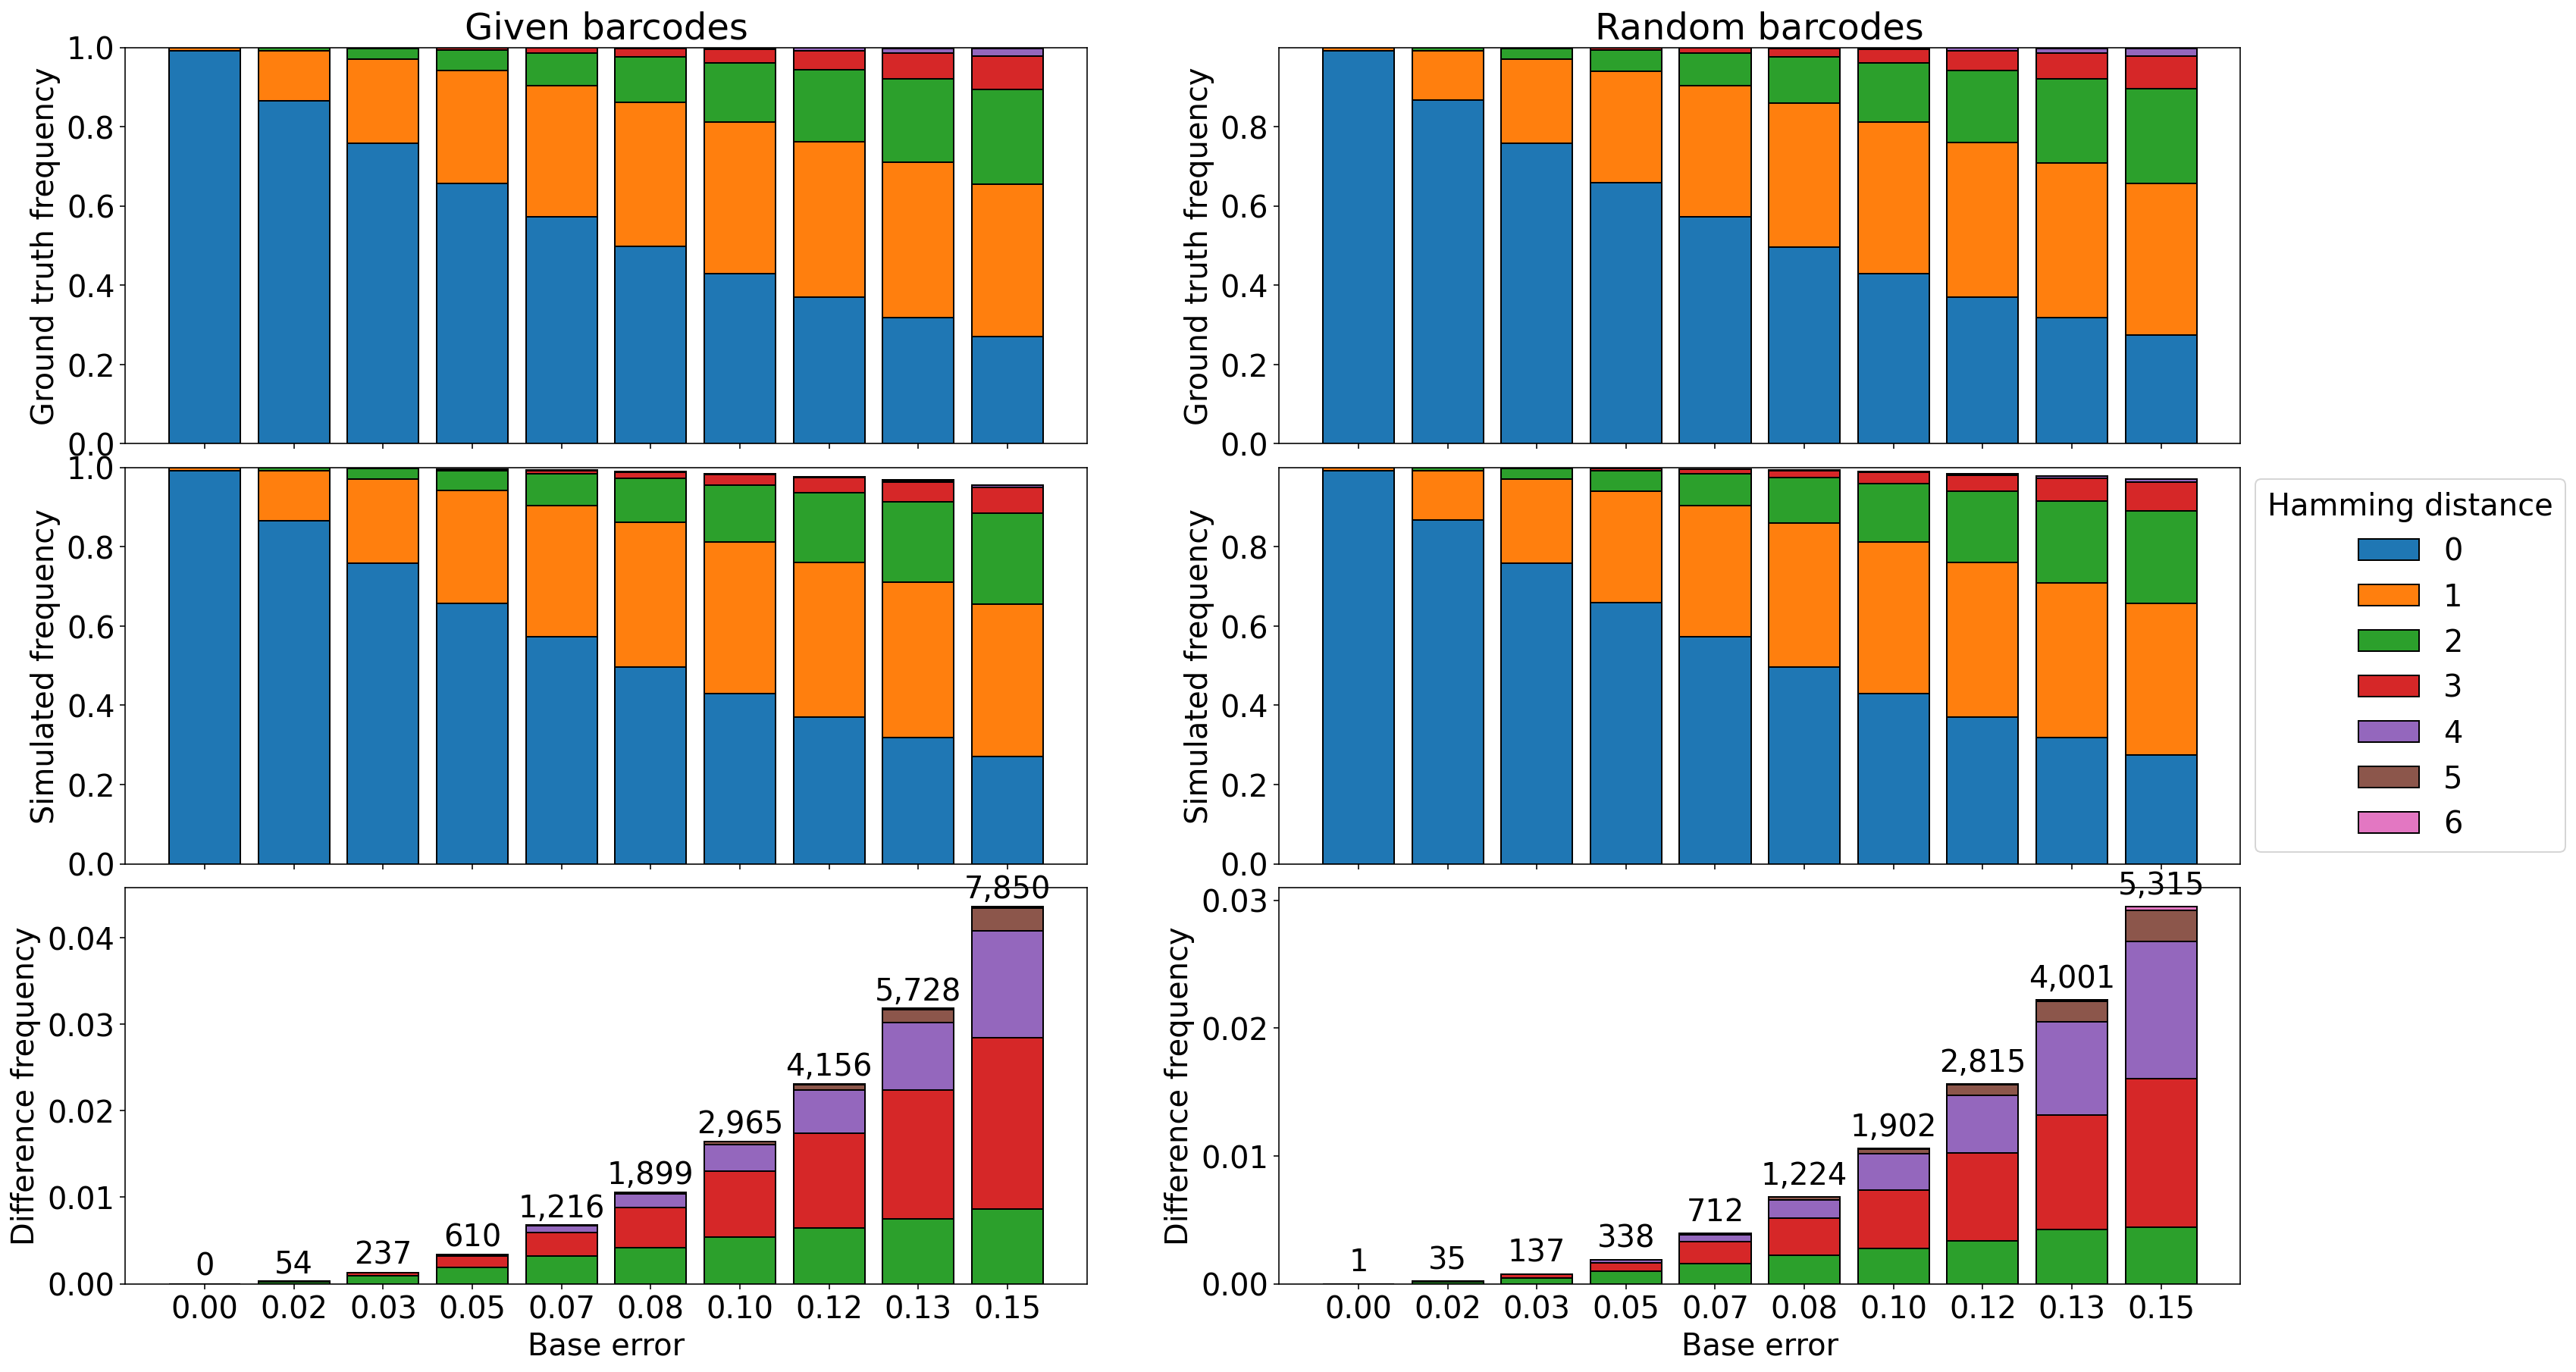

In [139]:
fig, axs = plt.subplots(figsize=(25,15), nrows=3, ncols=2)
fig.subplots_adjust(hspace=0.06)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Gen
# toggle = itertools.cycle(["white", "grey"]).__next__
ax = axs[0, 0]

mat = (gen.T/N/n_bcs).copy()

x = np.arange(err.shape[0])
y = mat[0]
ax.bar(x,y, edgecolor="k")#, facecolor=toggle())
for r in mat[1:]:
  ax.bar(x,r, bottom=y, edgecolor="k")#, facecolor=toggle())
  y+=r

ax.set(**{
    "title": "Given barcodes",
    "xlabel": "",
    "ylabel": "Ground truth frequency",
    "xticklabels": [],
    "xticks": x,
})

## Sim
# toggle = itertools.cycle(["white", "grey"]).__next__
ax = axs[1, 0]

mat = (sim.T/N/n_bcs).copy()

x = np.arange(err.shape[0])
y = mat[0]
ax.bar(x,y, edgecolor="k")#, facecolor=toggle())
for r in mat[1:]:
  ax.bar(x,r, bottom=y, edgecolor="k")#, facecolor=toggle())
  y+=r

ax.set(**{
    "xlabel": "",
    "ylabel": "Simulated frequency",
    "xticklabels": [],
    "xticks": x,
})

## Difference
ax = axs[2, 0]
mat = (gen.T/N/n_bcs).copy() - (sim.T/N/n_bcs).copy()

x = np.arange(err.shape[0])
y = mat[0]
ax.bar(x,y, edgecolor="k")#, facecolor=toggle())
for r in mat[1:]:
  ax.bar(x,r, bottom=y, edgecolor="k")#, facecolor=toggle())
  y+=r

for idx, (xx, yy) in enumerate(zip(x,y)):
  ax.text(xx, yy+0.001, f"{(gen.T - sim.T).sum(0)[idx]:,.0f}", ha="center", rotation=0)

ax.set(**{
    "xlabel": "Base error",
    "ylabel": "Difference frequency",
    "xticklabels": [f"{i:,.2f}" for i in err],
    "xticks": x,
})

######################################################################################################## Random
## Gen
# toggle = itertools.cycle(["white", "grey"]).__next__
ax = axs[0, 1]

mat = (r_gen.T/N/n_bcs).copy()

x = np.arange(err.shape[0])
y = mat[0]
ax.bar(x,y, edgecolor="k")#, facecolor=toggle())
for r in mat[1:]:
  ax.bar(x,r, bottom=y, edgecolor="k")#, facecolor=toggle())
  y+=r

ax.set(**{
    "title": "Random barcodes",
    "xlabel": "",
    "ylabel": "Ground truth frequency",
    "xticklabels": [],
    "xticks": x,
})

## Sim
# toggle = itertools.cycle(["white", "grey"]).__next__
ax = axs[1, 1]

mat = (r_sim.T/N/n_bcs).copy()

x = np.arange(err.shape[0])
y = mat[0]

ax.bar(x,y, edgecolor="k", label=np.arange(max_ham)[0])#, facecolor=toggle())
for idx, r in enumerate(mat[1:], 1):
  ax.bar(x,r, bottom=y, edgecolor="k", label=np.arange(max_ham)[idx])#, facecolor=toggle())
  y+=r

ax.set(**{
    "xlabel": "",
    "ylabel": "Simulated frequency",
    "xticklabels": [],
    "xticks": x,
})

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Hamming distance")

## Difference
ax = axs[2, 1]
mat = (r_gen.T/N/n_bcs).copy() - (r_sim.T/N/n_bcs).copy()

x = np.arange(err.shape[0])
y = mat[0]
ax.bar(x,y, edgecolor="k")#, facecolor=toggle())
for r in mat[1:]:
  ax.bar(x,r, bottom=y, edgecolor="k")#, facecolor=toggle())
  y+=r

for idx, (xx, yy) in enumerate(zip(x,y)):
  ax.text(xx, yy+0.001, f"{(r_gen.T - r_sim.T).sum(0)[idx]:,.0f}", ha="center", rotation=0)

ax.set(**{
    "xlabel": "Base error",
    "ylabel": "Difference frequency",
    "xticklabels": [f"{i:,.2f}" for i in err],
    "xticks": x,
})


fig.show()

In [140]:
# how many barcodes can be unambigously corrected at that error/HD pair?